In [ ]:
! pip install kaggle

In [ ]:
# configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village

100% 329M/329M [00:03<00:00, 113MB/s] 
100% 329M/329M [00:03<00:00, 106MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plant-village.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential,models
from keras.models import Model
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.math import confusion_matrix
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'PlantVillage',
     shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

(32, 256, 256, 3)
[0 0 1 1 0 0 2 1 1 0 2 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1]


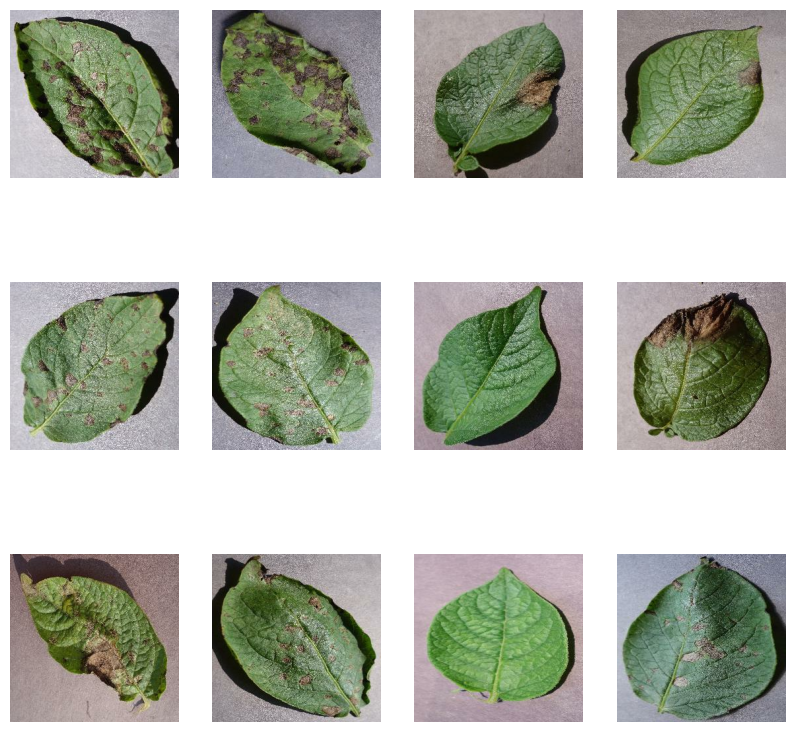

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1) # plt.figure(figsize=(3,4))
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')

**Train test split**

80% ---> training

20% ---> 10% test     10% validation

In [ ]:
train_size =0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True ,shuffle_size=1000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)


  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape = input_shape),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(n_classes,activation='softmax')

])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50
54/54 [==============================] - 15s 96ms/step - loss: 0.8943 - accuracy: 0.5098 - val_loss: 0.8020 - val_accuracy: 0.6042
Epoch 2/50
54/54 [==============================] - 3s 60ms/step - loss: 0.6182 - accuracy: 0.7199 - val_loss: 0.4046 - val_accuracy: 0.8438
Epoch 3/50
54/54 [==============================] - 3s 61ms/step - loss: 0.4011 - accuracy: 0.8328 - val_loss: 0.2468 - val_accuracy: 0.8906
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2735 - accuracy: 0.8843 - val_loss: 0.2625 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 3s 62ms/step - loss: 0.2633 - accuracy: 0.8877 - val_loss: 0.1598 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2032 - accuracy: 0.9155 - val_loss: 0.3262 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2402 - accuracy: 0.8981 - val_loss: 0.1783 - val_accuracy: 0.9271
Epoch 8/50
5

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 27ms/step - loss: 0.1706 - accuracy: 0.9414


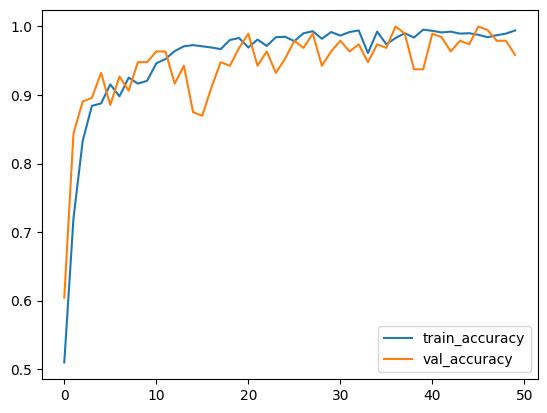

In [ ]:
#plot on accuracy value
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

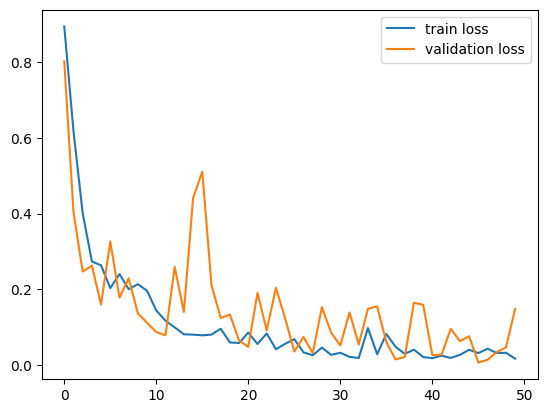

In [ ]:
#plot on loss vallue
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 28ms/step
predicted label: Potato___healthy


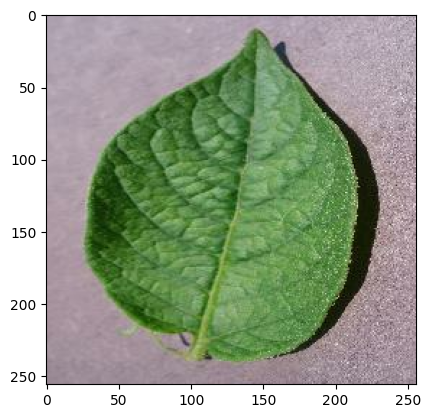

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 78ms/step


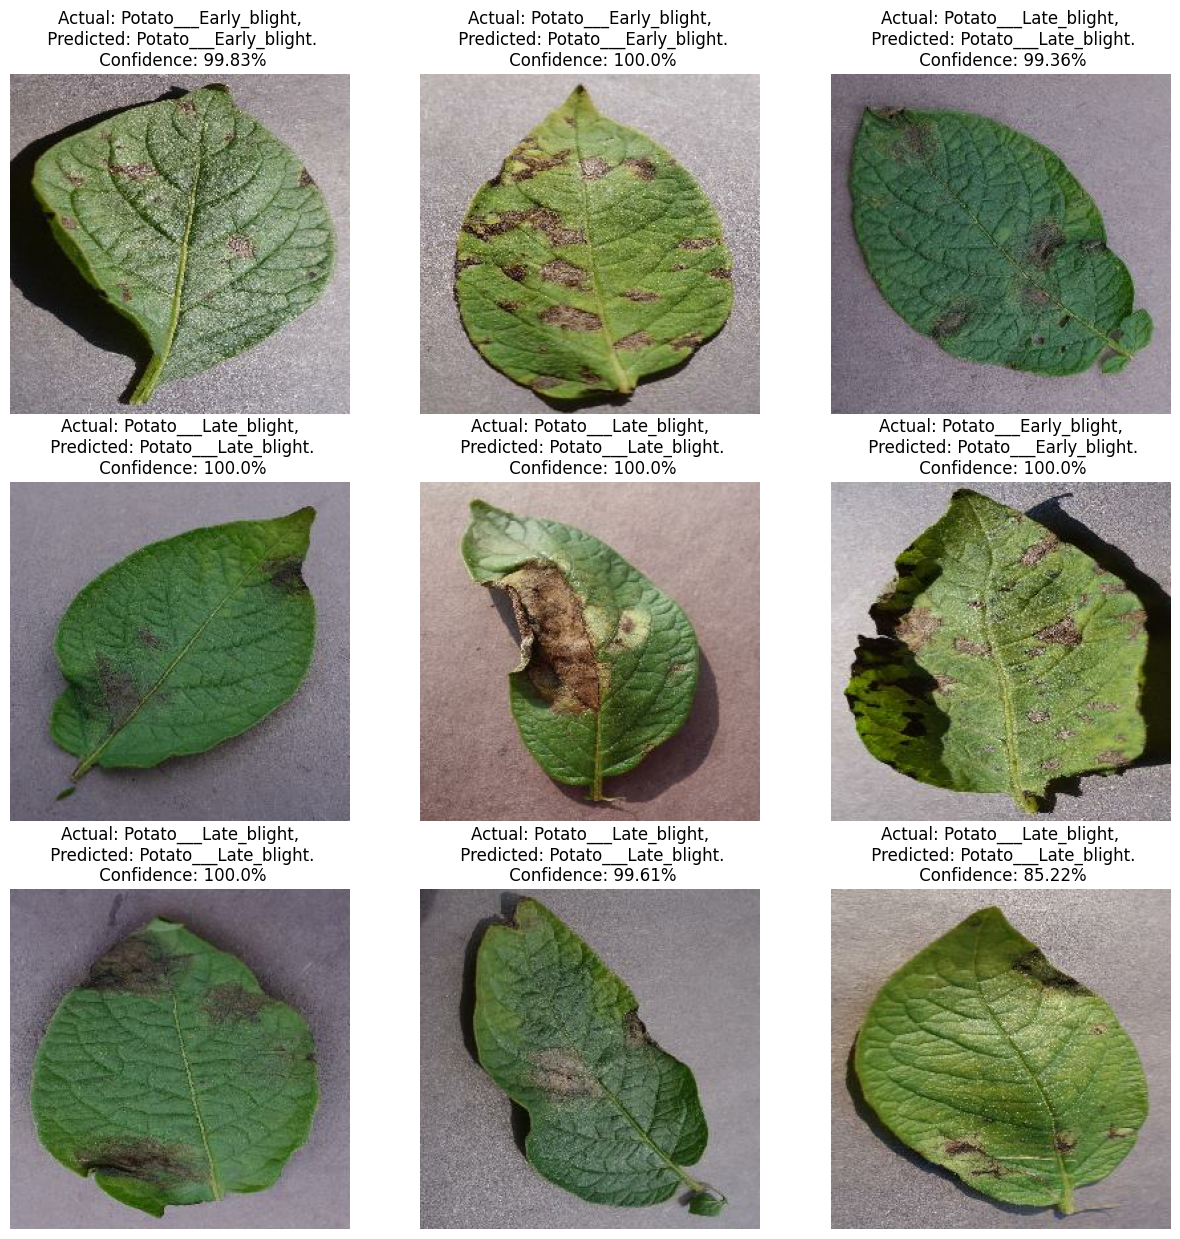

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
modelversion=1
model.save(f'/content/{modelversion}')